# Analyze Whatsapp Discussion
In this notebook we will analyze an exported Whatsapp discussion

if you want to use it for your personal discussions, first of all make sure that 
1. Your phone language is **English**
2. Your phone's time format is **24-hour** and NOT 12-hour

**The conditions above are necessary**

Then follow these steps to export your chat:

* Go to the desired discussion
* Click the three dots at the top right
* Click _More_ then _Export_
* Choose _Without Media_
* Whatsapp will give you a text file, put it in the same directory with this Notebook
* Modify the constant below with your filename

Note: This works for group discussions too!

In [1]:
FILENAME = "Whatsapp Chat with Youssef.txt"

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from datetime import datetime
import calendar

from collections import Counter
from emoji import UNICODE_EMOJI

## Plots customization

In [3]:
sns.set_style('darkgrid')
sns.set_context("poster", font_scale = 0.7, rc={"grid.linewidth": 1.5})
from matplotlib import rcParams
rcParams['figure.figsize'] = 23,8.27

## Data preparation
### Extract messages

In [4]:
class Message:
    def __init__(self, date, time, name, text):
        self.date = date
        self.time = time
        self.name = name
        self.text = text
    def arr(self):
        return [self.date + " " + self.time, self.name, self.text]

In [5]:
f = open(FILENAME, encoding='utf8')
sample = f.read()
lines = sample.split("\n")
idx = len(lines) - 1
for msg in range(len(lines)):
    is_match = bool(re.match('^\d\d?\/\d\d?\/\d\d', lines[idx]))
    if (not is_match):
        lines[idx-1] = lines[idx-1] + '\n{}'.format(lines[idx])
        lines[idx] = ''

    idx = idx - 1
lines = list(filter(bool, lines))

data = []
for msg in lines:
    try:
        date = msg.split()[0][:-1]
        time = msg.split()[1]
        if(len(msg.split(': ')) != 1):
            name = msg.split()[3].replace(':', '')
            text = ": ".join(msg.split(": ")[1:])
        else:
            name = None
            text = " ".join(msg.split('- ')[1:])
        row = Message(date, time, name, text)
        data.append(row.arr())
    except Exception as e:
        print(e)

df = pd.DataFrame(data, columns=['date', 'username', 'text'])

### Data cleaning and transforming

We turn the data in the date column to a timestamp object so we can analyze it more easily

In [6]:
df['date'] = df["date"].apply(lambda x:datetime.strptime(x, '%m/%d/%y %H:%M'))

In [7]:
type(df.iloc[0]["date"])

pandas._libs.tslibs.timestamps.Timestamp


We check if our df has missing values

In [8]:
df.isnull().sum()

date        0
username    5
text        0
dtype: int64

seems like we have missing usernames

we drop the rows with missing usernames

In [9]:
df.dropna(inplace=True)

We verify that our data is clean now

In [10]:
df.isnull().sum()

date        0
username    0
text        0
dtype: int64

Seems good!

Now we create essential columns for our analysis

**words count**: number of words within the message

**letters count**: number of letters within the message

**day**: day name of message

**month**: month name of message

**hour**: hour of message

In [11]:
df["words count"] = df["text"].apply(lambda x:len(x.split()))
df["letters count"] = df["text"].apply(len)
df['day'] = df['date'].apply(lambda x:calendar.day_name[x.weekday()])
df['month'] = df['date'].apply(lambda x:calendar.month_name[x.month])
df["hour"] = df["date"].apply(lambda x:x.hour)

Two functions to help us with emojis

First one used to extract emojis from a message

Second one to verify whether a letter is an emoji or not

In [12]:
def extract_emojis(message):
    arr = []
    for letter in message:
        if(is_emoji(letter)):
            arr.append(letter)
    return "".join(arr)

def is_emoji(s):
    return s in UNICODE_EMOJI["en"]

Now we create two more columns

**emojis**: containing the emojis within the text, if there are any

**emojis count**: number of emojis withing a message, if there are any

In [13]:
df["emojis"] = df["text"].apply(extract_emojis)
df["emojis count"] = df["emojis"].apply(len)

### Text messages preprocessing

We will need to analyze the text messages, to know the most used words

First we get all the words in texts

In [14]:
words = " ".join(df["text"]).split()

and we get all the words in texts for each user too! we're going to need this

In [15]:
words_per_user = {}
for user in df.groupby("username")["text"]:
    words_per_user[user[0]] = " ".join(user[1]).split()

Let's do some cleaning now

#### We normalize the case

In [16]:
words = [word.lower() for word in words]
for user in words_per_user:
    words_per_user[user] = [word.lower() for word in words_per_user[user]]

#### we remove words with less than 5 characters, words that are not a message

In [17]:
import string
def get_clean(word):
    if(len(word) < 5 or word in ('<media', 'omitted>')):
        return False
    return True

words = list(filter(get_clean, words))
for user in words_per_user:
    words_per_user[user] = list(filter(get_clean, words_per_user[user]))

#### We remove punctuation

In [18]:
table = str.maketrans('', '', string.punctuation)
words = [w.translate(table) for w in words]
words = list(filter(bool, words))
for user in words_per_user:
    words_per_user[user] = [w.translate(table) for w in words_per_user[user]]
    words_per_user[user] = list(filter(bool, words_per_user[user]))

#### We remove emojis

In [19]:
for idx, word in enumerate(words):
    words[idx] = list(words[idx])
    for idx_2, letter in enumerate(words[idx]):
        if(is_emoji(letter)):
            words[idx][idx_2] = ''
    words[idx] = "".join(words[idx])
words = list(filter(bool, words))

for user in words_per_user:
    for idx, word in enumerate(words_per_user[user]):
        words_per_user[user][idx] = list(words_per_user[user][idx])
        for idx_2, letter in enumerate(words_per_user[user][idx]):
            if(is_emoji(letter)):
                words_per_user[user][idx][idx_2] = ''
        words_per_user[user][idx] = "".join(words_per_user[user][idx])
    
    words_per_user[user] = list(filter(bool, words_per_user[user]))

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39988 entries, 1 to 39992
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           39988 non-null  datetime64[ns]
 1   username       39988 non-null  object        
 2   text           39988 non-null  object        
 3   words count    39988 non-null  int64         
 4   letters count  39988 non-null  int64         
 5   day            39988 non-null  object        
 6   month          39988 non-null  object        
 7   hour           39988 non-null  int64         
 8   emojis         39988 non-null  object        
 9   emojis count   39988 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 3.4+ MB


In [ ]:
df.head()

Everything seems alright! let's have some fun now

## Visualizations

### Number of messages sent by users (including media messages)

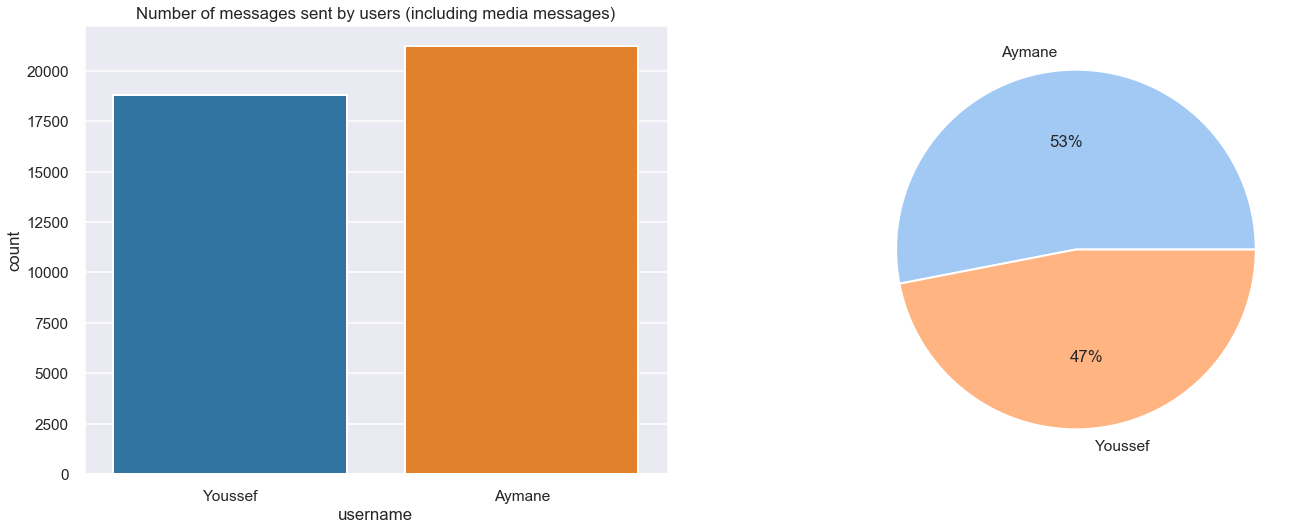

In [22]:
plt.subplot(1,2,1)
sns.countplot(x="username", data=df).set_title("Number of messages sent by users (including media messages)")

plt.subplot(1,2,2)
data = df["username"].value_counts().values
labels = df["username"].value_counts().keys()
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')

plt.show()

### Number of messages sent by users (including media messages)

In order to visualize more clearly just the _text_ messages

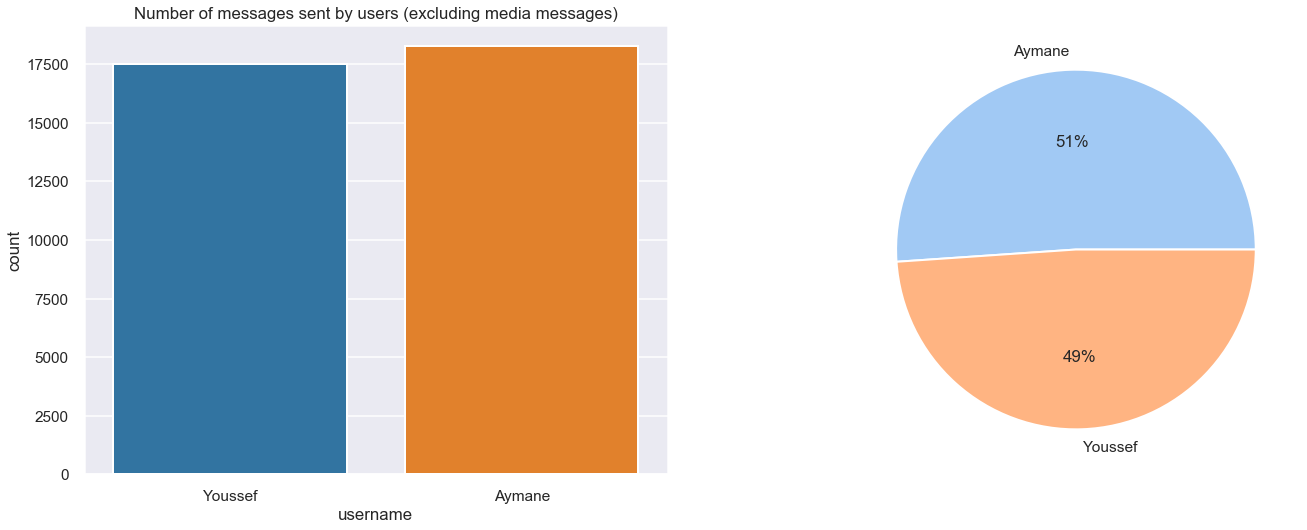

In [23]:
df_without_media = df[df['text']!='<Media omitted>']

plt.subplot(1,2,1)
sns.countplot(x="username", data=df_without_media).set_title("Number of messages sent by users (excluding media messages)")

plt.subplot(1,2,2)
data = df_without_media["username"].value_counts().values
labels = df_without_media["username"].value_counts().keys()
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')

plt.show()

### Number of words sent by users

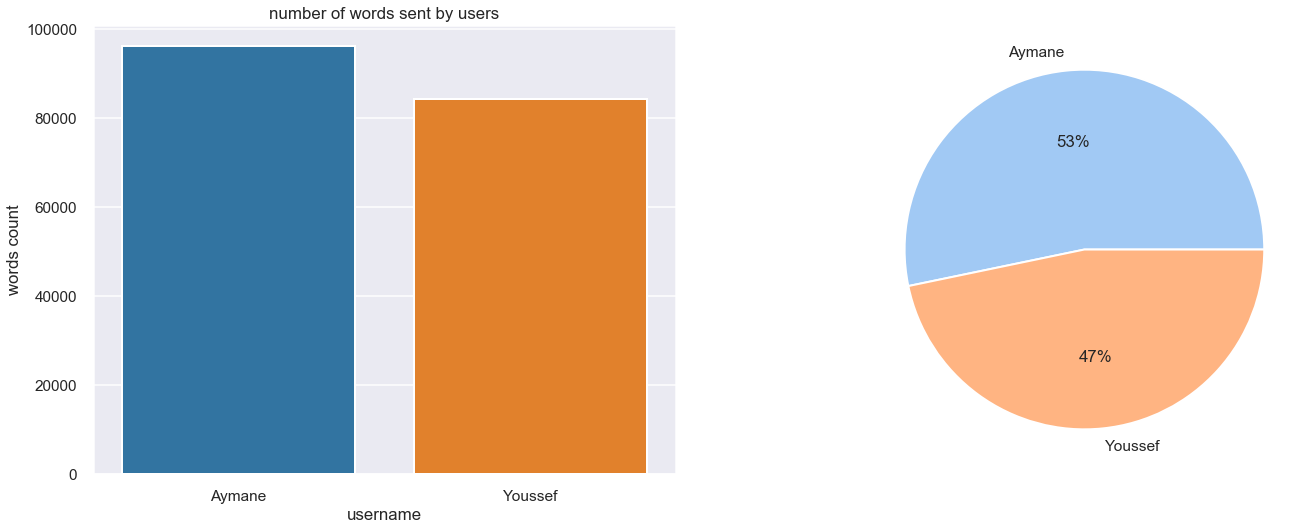

In [24]:
plt.subplot(1,2,1)
ax = sns.barplot(x=df.groupby(["username"]).sum().index, y=df.groupby(["username"])["words count"].sum().values)
ax.set_title("number of words sent by users")
ax.set(ylabel="words count")

plt.subplot(1,2,2)
data = df.groupby(["username"])["words count"].sum().values
labels = df.groupby(["username"]).sum().index
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')

plt.show()

### Who writes longer messages?

In [25]:
x = df.groupby("username").mean()["letters count"]
data_lm = sorted(x.items(), key=lambda item: item[1], reverse=True)
data_lm
print("1- **{}** is the one who writes longer messages with an average of {:.2f} letters per message.".format(data_lm[0][0], data_lm[0][1]))
i = 2
for idx, name in data_lm[1:]:
    print("{}- {} writes an average of {:.2f} letters per message.".format(i, idx, name))
    i += 1

1- **Aymane** is the one who writes longer messages with an average of 26.25 letters per message.
2- Youssef writes an average of 24.21 letters per message.


### Messages per weekday

We use a pie plot to visualize the dispersion of messages around the week

and a bar plot to visualize the contribution of each user

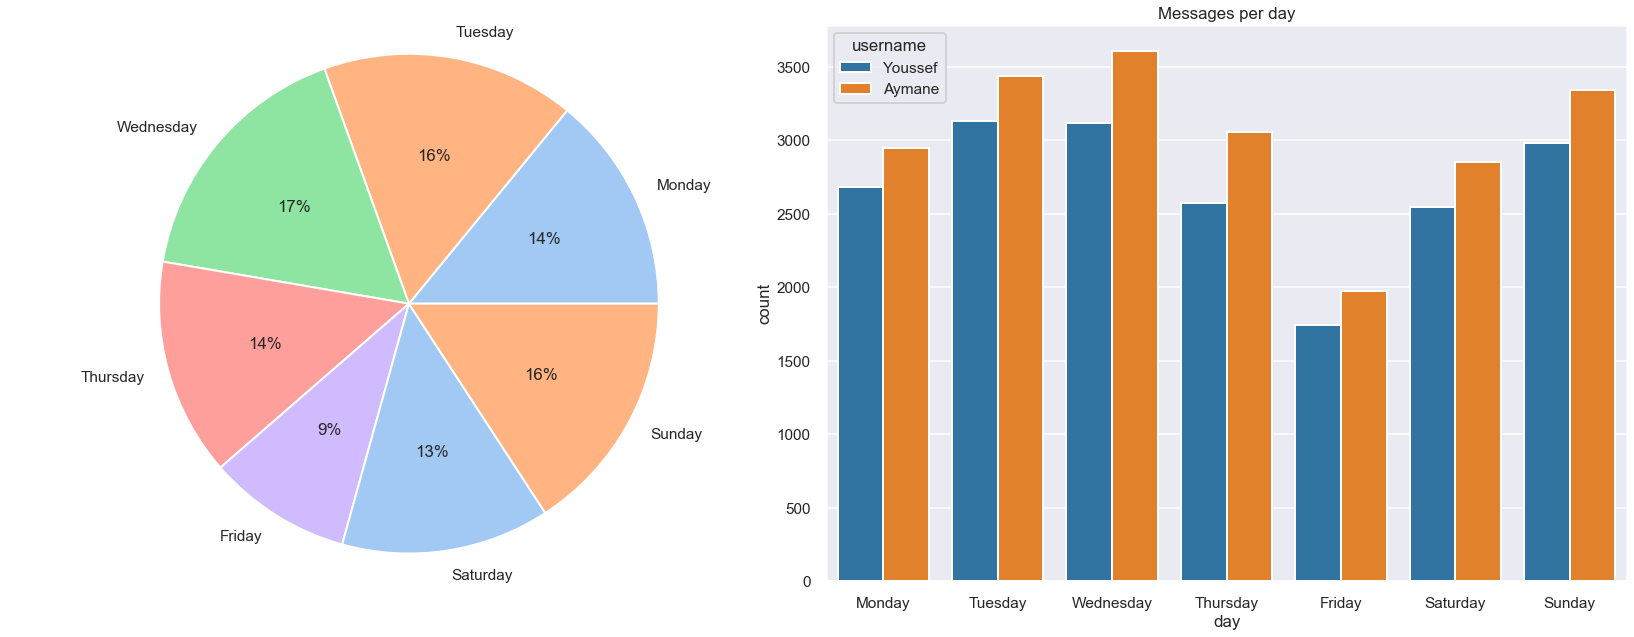

In [26]:
count_per_day = df["day"].value_counts()[list(calendar.day_name)]
data = count_per_day.values
labels = count_per_day.keys()
colors = sns.color_palette('pastel')[0:5]

plt.subplot(1,2,1)
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.axis('equal')
plt.tight_layout()

plt.subplot(1,2,2)
sns.countplot(x="day", hue="username", data=df, order=list(calendar.day_name)).set_title("Messages per day")

plt.show()

### Messages per month
We do the same for months

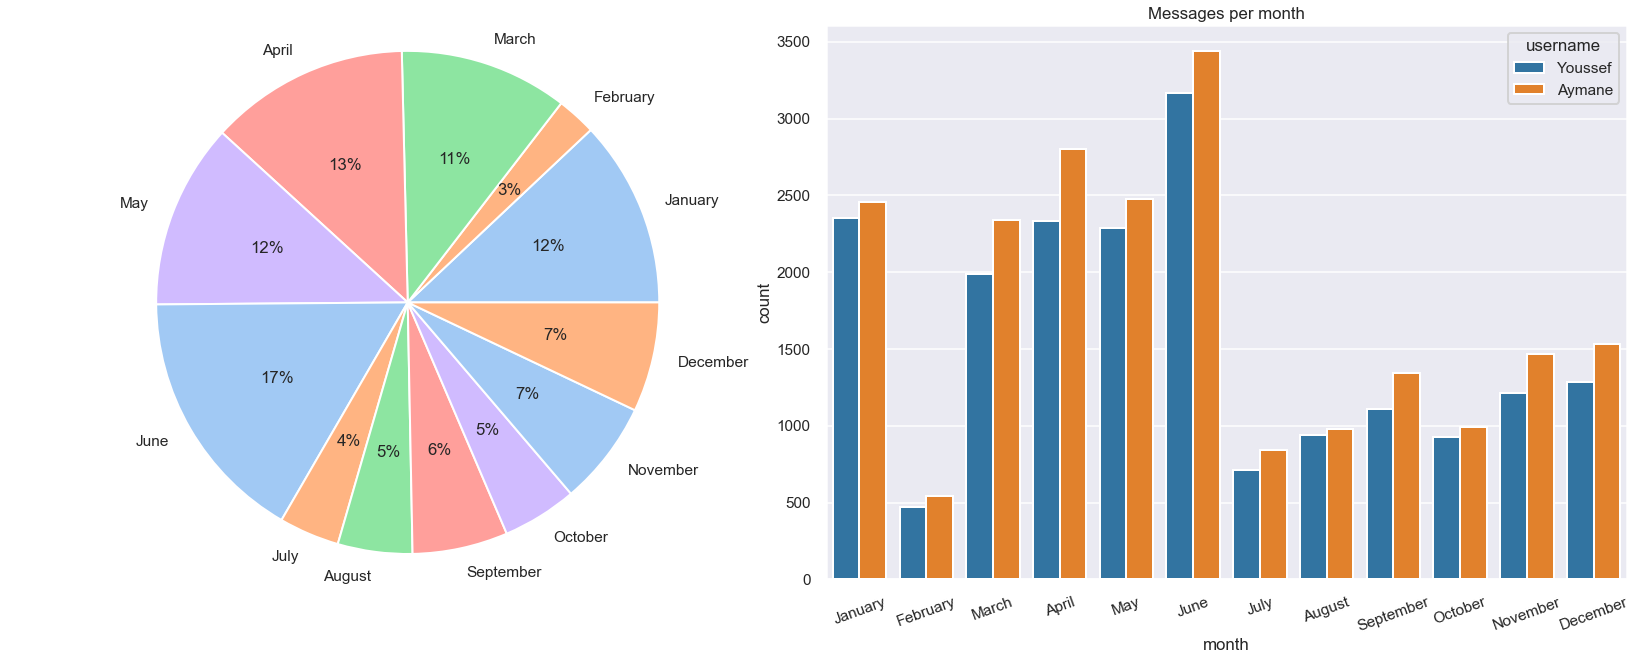

In [27]:
try:
    count_per_month = df["month"].value_counts()[list(calendar.month_name)[1:]]
except:
    count_per_month = df["month"].value_counts()
    
data = count_per_month.values
labels = count_per_month.keys()
colors = sns.color_palette('pastel')[0:5]

plt.subplot(1,2,1)
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.axis('equal')
plt.tight_layout()

plt.subplot(1,2,2)
sns.countplot(x="month", hue="username", data=df, order=list(calendar.month_name[1:])).set_title("Messages per month")
plt.xticks(rotation=20)

plt.show()

### Longest messages

In [28]:
for idx in df.groupby("username").idxmax()["letters count"]:
    print('Longest message by     *{}*'.format(df.loc[idx]["username"]))
    print('Was sent on             {}'.format(df.loc[idx]["date"]))
    print('It contains             {} words, {} letters'.format(df.loc[idx]["words count"], df.loc[idx]["letters count"]))
    print("\n")

Longest message by     *Aymane*
Was sent on             2021-11-09 11:41:00
It contains             477 words, 2587 letters


Longest message by     *Youssef*
Was sent on             2021-07-01 23:42:00
It contains             360 words, 2129 letters




If you want to read the longest messages run the next cell

In [ ]:
for idx in df.groupby("username").idxmax()["letters count"]:
    print("Longest message by {}:\n".format(df.loc[idx]["username"]))
    print(df.loc[idx]["text"])
    print("--------------------\n")

### Messages per hour

Text(0.5, 1.0, 'Messages per hour')

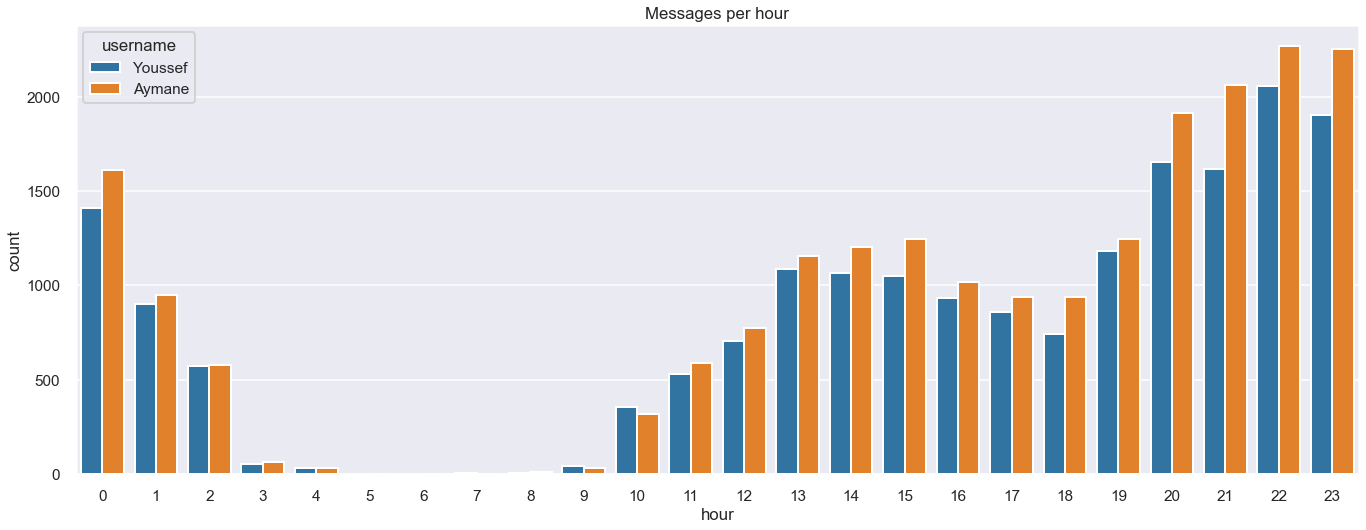

In [30]:
sns.countplot(x="hour", hue="username", data=df, order=list(range(24))).set_title("Messages per hour")

### Most used words
Here are the most used words

In [31]:
most_common = Counter(words).most_common(8)
most_common

[('dakchi', 395),
 ('chwya', 390),
 ('ghadi', 390),
 ('brojola', 281),
 ('hadchi', 278),
 ('bghit', 251),
 ('wlkin', 248),
 ('wakha', 244)]

Absolutely not eye pleasing, what about a bar plot?

Text(0.5, 1.0, 'Most used words in discussion')

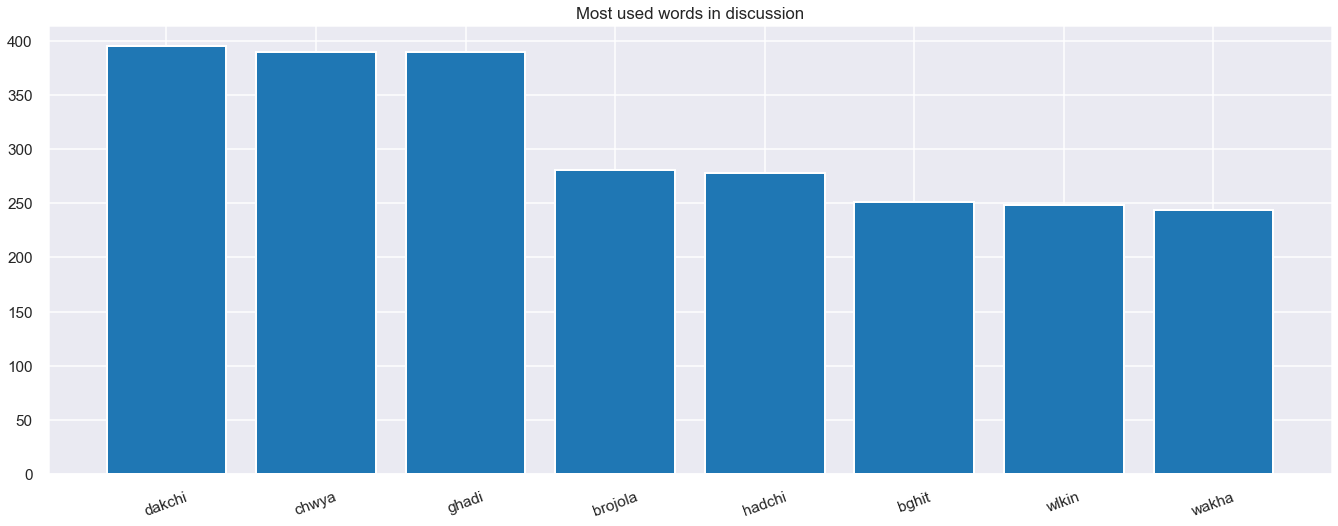

In [32]:
common_words = list(zip(*most_common))[0]
score = list(zip(*most_common))[1]

plt.bar(common_words, score, align='center')
plt.xticks(rotation=20)
plt.title("Most used words in discussion")

but what about the most words used by each user? that would be more interesting

### Most used words by each user

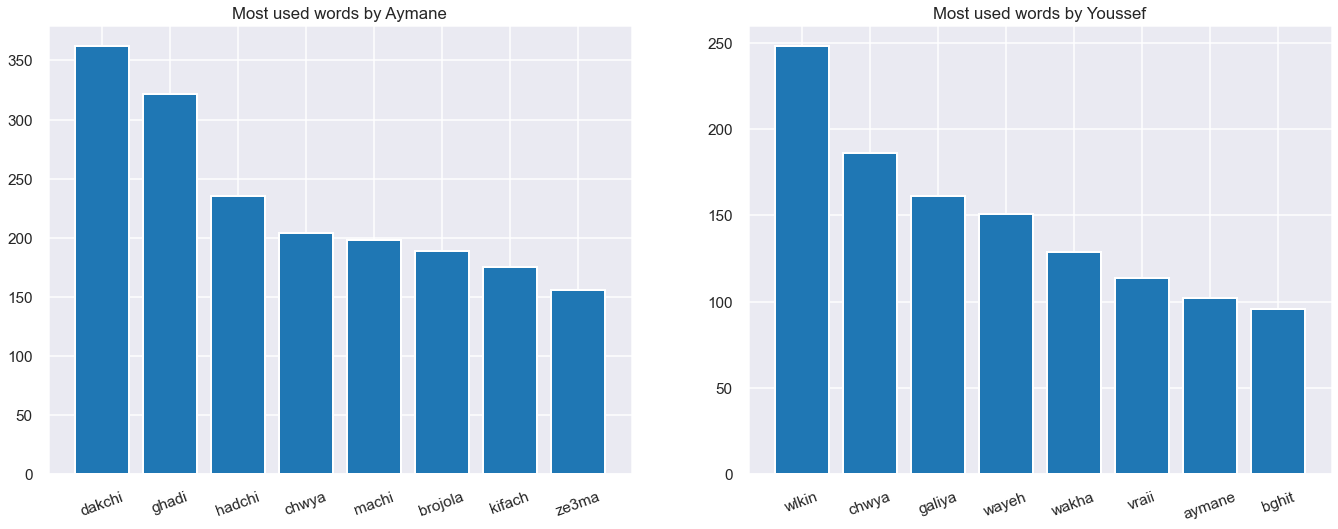

In [33]:
i = 1
ncols = 2
nrows = len(words_per_user) // ncols + (len(words_per_user) % ncols > 0)
for user in words_per_user:
    most_common = Counter(words_per_user[user]).most_common(8)
    common_words = list(zip(*most_common))[0]
    score = list(zip(*most_common))[1]
    
    plt.subplot(nrows,ncols,i)
    plt.bar(common_words, score, align='center')
    plt.title("Most used words by {}".format(user))
    plt.xticks(rotation=20)
    plt.tight_layout()
    i += 1

### Most used emojis

In [34]:
most_common_emojis = Counter("".join(df["emojis"])).most_common(6)
print("Most used emojis in the discussion:")
for emoji, score in most_common_emojis:
    print('{} used {} times'.format(emoji, score))

Most used emojis in the discussion:
😂 used 5075 times
🤣 used 401 times
😭 used 38 times
❤ used 26 times
😎 used 15 times
😛 used 8 times


### Most used emojis per user

In [35]:
emojis_per_user = {}
for user in df.groupby("username")["emojis"]:
    emojis_per_user[user[0]] = " ".join(user[1]).split()

for user in emojis_per_user:
    most_common_emojis = Counter("".join(emojis_per_user[user])).most_common(6)
    print("Most used emojis by {}:".format(user))
    for emoji, score in most_common_emojis:
        print('{} used {} times'.format(emoji, score))
    
    print("\n")

Most used emojis by Aymane:
😂 used 1607 times
🤣 used 378 times
😭 used 33 times
😎 used 15 times
❤ used 11 times
😛 used 8 times


Most used emojis by Youssef:
😂 used 3468 times
🤣 used 23 times
❤ used 15 times
😭 used 5 times
😢 used 5 times
🥰 used 3 times




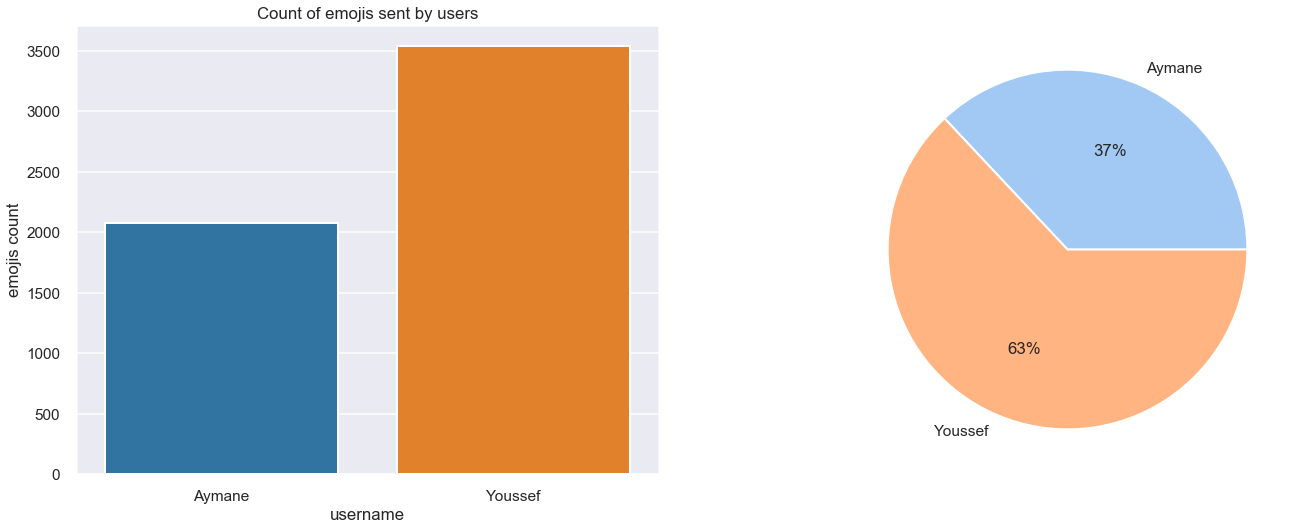

In [36]:
plt.subplot(1,2,1)
ax = sns.barplot(x=df.groupby(["username"]).sum().index, y=df.groupby(["username"])["emojis count"].sum().values)
ax.set(ylabel="emojis count")
ax.set_title("Count of emojis sent by users")

plt.subplot(1,2,2)
data = df.groupby(["username"])["emojis count"].sum().values
labels = df.groupby(["username"]).sum().index
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')

plt.show()